# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2a43ef796df82644ea0bbccda575b3dd60b5c82e192b05a83d43f5cfd6edaa4b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=44152bc009ed0e0a08036f5b23edc4a6d6c645e2f9b1ae9141340a9efb38c0cc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (3/3), done.


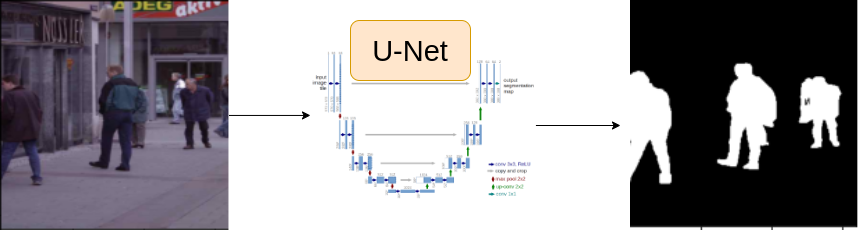

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [8]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = "cuda"

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [9]:
df = pd.read_csv(CSV_FILE)
df.head

<bound method NDFrame.head of                                                  masks  \
0    Human-Segmentation-Dataset-master/Ground_Truth...   
1    Human-Segmentation-Dataset-master/Ground_Truth...   
2    Human-Segmentation-Dataset-master/Ground_Truth...   
3    Human-Segmentation-Dataset-master/Ground_Truth...   
4    Human-Segmentation-Dataset-master/Ground_Truth...   
..                                                 ...   
285  Human-Segmentation-Dataset-master/Ground_Truth...   
286  Human-Segmentation-Dataset-master/Ground_Truth...   
287  Human-Segmentation-Dataset-master/Ground_Truth...   
288  Human-Segmentation-Dataset-master/Ground_Truth...   
289  Human-Segmentation-Dataset-master/Ground_Truth...   

                                                images  
0    Human-Segmentation-Dataset-master/Training_Ima...  
1    Human-Segmentation-Dataset-master/Training_Ima...  
2    Human-Segmentation-Dataset-master/Training_Ima...  
3    Human-Segmentation-Dataset-master/Traini

In [13]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


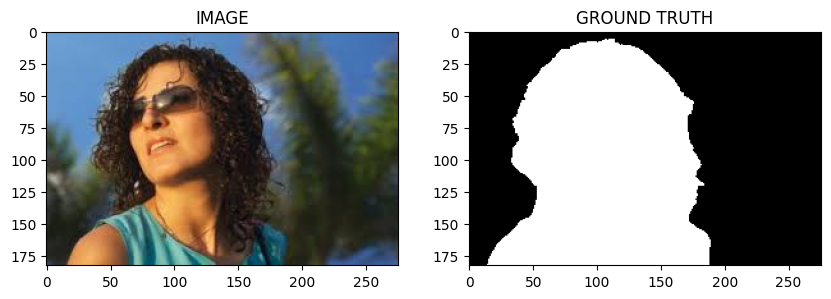

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [18]:
# we only augment the images, not labels for classificatio datasets.
# For segmentation, we rotate both images and labels

import albumentations as A

In [40]:
# apply to training dataset
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

# apply to inference
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [41]:
# get mask and image pair according to event index
from torch.utils.data import Dataset

In [42]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  # return image, mask pair according to index
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # mask at grayscale only has two dimension, (height, width)
    # we will add a channel dimension to mask image to have (h, w, c)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      # return images and masks in dictionary format
      data = self.augmentations(image = image, mask = mask)

      # extract image and mask from the dictionary
      image = data['image']
      mask = data['mask']

      # reformat the dimensions to pytorch format (c, h, w)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      # convert np arrays to tensors
      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [43]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [44]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


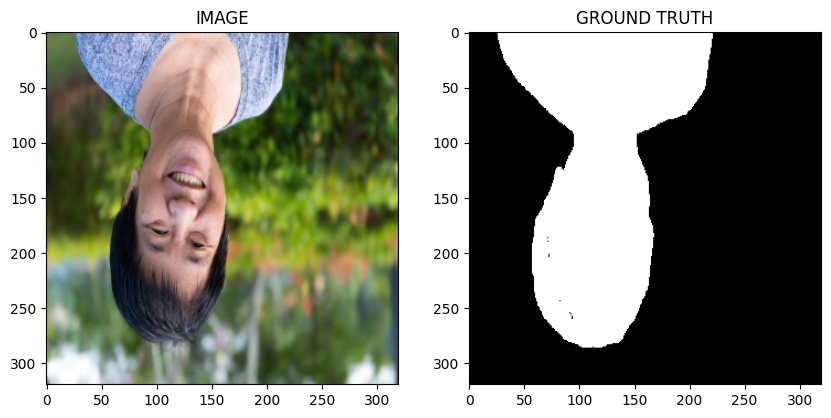

In [45]:
idx = 3

image, mask = trainset[idx]
print(image.shape)
print(mask.shape)
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [46]:
from torch.utils.data import DataLoader

In [47]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [48]:
print(f"total no. of batches in trainloade: {len(trainloader)}")
print(f"total no. of batches in validloade: {len(validloader)}")

total no. of batches in trainloade: 15
total no. of batches in validloade: 4


In [50]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [51]:
# use segmentation_models_pythorch for encoder and loss functions
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [68]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits


In [70]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [71]:
def train_function(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss /len(data_loader)


In [78]:
def eval_function(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss /len(data_loader)

# Task 8 : Train Model

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [80]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_function(trainloader, model, optimizer)
  valid_loss = eval_function(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print(f"SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED-MODEL
Epoch: 1 Train_loss : 0.39371977051099144 valid_loss : 0.27494264394044876


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


Epoch: 2 Train_loss : 0.2833641181389491 valid_loss : 0.31126753613352776


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


SAVED-MODEL
Epoch: 3 Train_loss : 0.255224139491717 valid_loss : 0.26965710893273354


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


SAVED-MODEL
Epoch: 4 Train_loss : 0.2413307269414266 valid_loss : 0.23572152107954025


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 5 Train_loss : 0.2292685161034266 valid_loss : 0.33749593794345856


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


SAVED-MODEL
Epoch: 6 Train_loss : 0.21042058765888214 valid_loss : 0.19837767630815506


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


SAVED-MODEL
Epoch: 7 Train_loss : 0.21264182925224304 valid_loss : 0.190307829529047


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch: 8 Train_loss : 0.1857154443860054 valid_loss : 0.20571254193782806


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch: 9 Train_loss : 0.17264850040276844 valid_loss : 0.2719893269240856


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch: 10 Train_loss : 0.19889592578013737 valid_loss : 0.19797464087605476


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


SAVED-MODEL
Epoch: 11 Train_loss : 0.1471777578194936 valid_loss : 0.16709298267960548


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


SAVED-MODEL
Epoch: 12 Train_loss : 0.13334441284338633 valid_loss : 0.16026143729686737


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 13 Train_loss : 0.15054362465937932 valid_loss : 0.39625511318445206


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Epoch: 14 Train_loss : 0.22518044213453928 valid_loss : 0.2268127277493477


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch: 15 Train_loss : 0.1430562307437261 valid_loss : 0.21863524243235588


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch: 16 Train_loss : 0.12717106441656748 valid_loss : 0.2234155423939228


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch: 17 Train_loss : 0.1472139447927475 valid_loss : 0.319177970290184


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 18 Train_loss : 0.12678588579098385 valid_loss : 0.17586227133870125


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Epoch: 19 Train_loss : 0.1050411507487297 valid_loss : 0.21909374743700027


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 20 Train_loss : 0.1349088395635287 valid_loss : 0.2500505559146404


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 21 Train_loss : 0.13943237016598384 valid_loss : 0.27205558121204376


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch: 22 Train_loss : 0.11637427856524786 valid_loss : 0.28122735396027565


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch: 23 Train_loss : 0.10977867469191552 valid_loss : 0.22925685346126556


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch: 24 Train_loss : 0.16875637819369635 valid_loss : 0.18566083535552025


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

Epoch: 25 Train_loss : 0.1313101167480151 valid_loss : 0.16547752730548382


# Task 9 : Inference

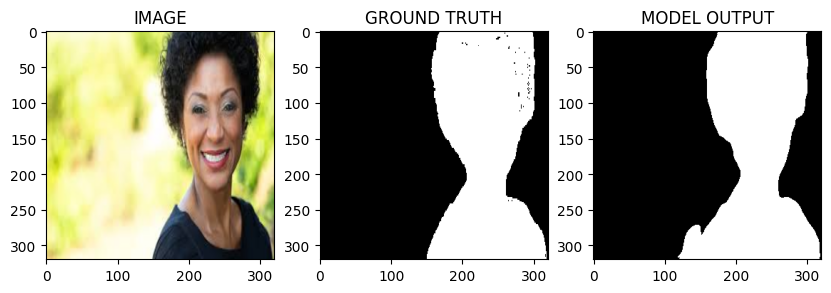

In [84]:
idx = 2
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # add batch dimension

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya